<a href="https://colab.research.google.com/github/minofeel/-/blob/main/Efficientnet(%EB%94%94%EC%B9%B4F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 설치
!pip install torch torchvision opencv-python-headless

In [ ]:
# Colab 파일 업로드 기능을 사용하여 여러 이미지 파일 업로드
from google.colab import files
uploaded = files.upload()  # 여러 이미지 파일을 선택해서 업로드할 수 있습니다.

# 파일 저장 경로 생성 (모든 이미지를 저장할 폴더)
import os
upload_folder = '/content/uploaded_images'
os.makedirs(upload_folder, exist_ok=True)

# 업로드한 파일을 저장 폴더로 이동
for filename in uploaded.keys():
    with open(os.path.join(upload_folder, filename), 'wb') as f:
        f.write(uploaded[filename])

print(f"{len(uploaded)}개의 파일이 {upload_folder}에 업로드되었습니다.")

Saving 0002_01_F.jpg to 0002_01_F.jpg
Saving 0003_01_F.jpg to 0003_01_F.jpg
Saving 0006_01_F.jpg to 0006_01_F.jpg
Saving 0007_01_F.jpg to 0007_01_F.jpg
Saving 0008_01_F.jpg to 0008_01_F.jpg
Saving 0009_01_F.jpg to 0009_01_F.jpg
Saving 0010_01_F.jpg to 0010_01_F.jpg
Saving 0011_01_F.jpg to 0011_01_F.jpg
Saving 0012_01_F.jpg to 0012_01_F.jpg
Saving 0014_01_F.jpg to 0014_01_F.jpg
Saving 0016_01_F.jpg to 0016_01_F.jpg
Saving 0017_01_F.jpg to 0017_01_F.jpg
Saving 0018_01_F.jpg to 0018_01_F.jpg
Saving 0019_01_F.jpg to 0019_01_F.jpg
Saving 0020_01_F.jpg to 0020_01_F.jpg
Saving 0022_01_F.jpg to 0022_01_F.jpg
Saving 0023_01_F.jpg to 0023_01_F.jpg
Saving 0024_01_F.jpg to 0024_01_F.jpg
Saving 0025_01_F.jpg to 0025_01_F.jpg
Saving 0026_01_F.jpg to 0026_01_F.jpg
Saving 0027_01_F.jpg to 0027_01_F.jpg
Saving 0028_01_F.jpg to 0028_01_F.jpg
Saving 0029_01_F.jpg to 0029_01_F.jpg
Saving 0030_01_F.jpg to 0030_01_F.jpg
Saving 0031_01_F.jpg to 0031_01_F.jpg
Saving 0032_01_F.jpg to 0032_01_F.jpg
Saving 0033_

In [ ]:
# CSV 파일 업로드 (이미지 파일에 대한 나이 정보를 담고 있는 CSV 파일)
uploaded_csv = files.upload()
csv_filename = list(uploaded_csv.keys())[0]

import pandas as pd
csv_data = pd.read_csv(csv_filename)

Saving 디지털카메라 각도별 분류F.csv to 디지털카메라 각도별 분류F.csv


In [ ]:
# 전처리: 이미지 파일 경로와 나이 정보 로드
def load_data_from_csv(csv_data, image_folder):
    images, ages = [], []
    for _, row in csv_data.iterrows():
        image_path = os.path.join(image_folder, row['filename'])  # 'filename'을 실제 CSV 파일의 이미지 파일 이름 열로 대체
        age = row['age']  # 'age'를 실제 CSV 파일의 나이 정보 열로 대체
        if os.path.exists(image_path):  # 이미지 파일이 존재하는지 확인
            images.append(image_path)
            ages.append(age)
    return images, ages

image_paths, age_labels = load_data_from_csv(csv_data, upload_folder)

In [ ]:
# 데이터셋 클래스 정의
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class AgeDataset(Dataset):
    def __init__(self, image_paths, age_labels, transform=None):
        self.image_paths = image_paths
        self.age_labels = age_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        age = self.age_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, age

In [ ]:
# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 데이터셋 및 데이터로더 생성
dataset = AgeDataset(image_paths, age_labels, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class AgePredictionModel(nn.Module):
    def __init__(self):
        super(AgePredictionModel, self).__init__()
        # EfficientNet B1 모델 불러오기
        self.backbone = models.efficientnet_b1(weights="IMAGENET1K_V1")

        # 최종 레이어 추출 및 수정
        in_features = getattr(self.backbone.classifier, 'in_features', None)
        if in_features is not None:
            self.backbone.classifier = nn.Linear(in_features, 1)  # 회귀 출력을 위해 출력 차원을 1로 설정
        else:
            raise AttributeError("EfficientNet 모델에서 'in_features'를 찾을 수 없습니다.")

    def forward(self, x):
        return self.backbone(x)

# 모델 인스턴스 생성 및 장치로 이동
model = AgePredictionModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

AttributeError: EfficientNet 모델에서 'in_features'를 찾을 수 없습니다.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class AgePredictionModel(nn.Module):
    def __init__(self):
        super(AgePredictionModel, self).__init__()
        # EfficientNet B1 모델 불러오기
        self.backbone = models.efficientnet_b1(weights="IMAGENET1K_V1")

        # 최종 레이어의 입력 특징 수 추출 및 수정
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, 1)  # 회귀 출력을 위해 출력 차원을 1로 설정
        )

    def forward(self, x):
        return self.backbone(x)

# 모델 인스턴스 생성 및 장치로 이동
model = AgePredictionModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 연령대 구간 정의
age_intervals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # 연령대 구간
num_classes = len(age_intervals) - 1  # 연령대 수

# 연령대를 지정하는 함수
def age_to_age_group(age, age_intervals=age_intervals):
    for i, limit in enumerate(age_intervals[:-1]):
        if limit <= age < age_intervals[i+1]:
            return i
    return len(age_intervals) - 1  # 최대 연령대에 할당

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 예제 연령대 구간 정의
age_intervals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_classes = len(age_intervals) - 1

# 연령을 연령대 클래스로 변환하는 함수
def age_to_age_group(age, age_intervals=age_intervals):
    for i, limit in enumerate(age_intervals[:-1]):
        if limit <= age < age_intervals[i + 1]:
            return i
    return len(age_intervals) - 2

# 연령대 분류 모델 (마지막 레이어 출력 변경)
class AgeGroupClassificationModel(nn.Module):
    def __init__(self, base_model):
        super(AgeGroupClassificationModel, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(base_model.classifier[1].in_features, num_classes)  # EfficientNetB1 모델의 classifier 조정
        self.base_model.classifier[1] = self.fc  # 분류 레이어 대체

    def forward(self, x):
        return self.base_model(x)

# EfficientNet 모델에 연령대 분류 레이어 추가
base_model = models.efficientnet_b1(weights="IMAGENET1K_V1")
model = AgeGroupClassificationModel(base_model).to(device)

# 손실 함수 및 최적화
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# 학습 및 평가 함수
def train_age_group_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    start_time = time.time()
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, ages in train_loader:
            images = images.to(device)
            age_groups = torch.tensor([age_to_age_group(age) for age in ages.cpu().numpy()]).to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, age_groups)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, ages in val_loader:
                images = images.to(device)
                age_groups = torch.tensor([age_to_age_group(age) for age in ages.cpu().numpy()]).to(device).long()

                outputs = model(images)
                loss = criterion(outputs, age_groups)
                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(age_groups.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_age_group_model.pth")
            print(f"Validation loss improved to {best_val_loss:.4f}. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(classification_report(val_labels, val_preds, target_names=[f"{age_intervals[i]}-{age_intervals[i+1]-1}" for i in range(num_classes)]))

    return train_losses, val_losses

In [ ]:
# 학습 실행
train_losses, val_losses = train_age_group_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Validation loss improved to 1.6365. Model saved.
Epoch [1/100], Train Loss: 1.9929, Val Loss: 1.6365


ValueError: Number of classes, 6, does not match size of target_names, 10. Try specifying the labels parameter

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 예제 연령대 구간 재정의
age_intervals = [0, 20, 30, 40, 50, 60, 100]  # 10대 이하, 20대, 30대, 40대, 50대, 60대 이상
num_classes = len(age_intervals) - 1

# 연령을 연령대 클래스로 변환하는 함수
def age_to_age_group(age, age_intervals=age_intervals):
    for i, limit in enumerate(age_intervals[:-1]):
        if limit <= age < age_intervals[i + 1]:
            return i
    return len(age_intervals) - 2

# 연령대 분류 모델 (마지막 레이어 출력 변경)
class AgeGroupClassificationModel(nn.Module):
    def __init__(self, base_model):
        super(AgeGroupClassificationModel, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(base_model.classifier[1].in_features, num_classes)  # EfficientNetB1 모델의 classifier 조정
        self.base_model.classifier[1] = self.fc  # 분류 레이어 대체

    def forward(self, x):
        return self.base_model(x)

# EfficientNet 모델에 연령대 분류 레이어 추가
base_model = models.efficientnet_b1(weights="IMAGENET1K_V1")
model = AgeGroupClassificationModel(base_model).to(device)

# 손실 함수 및 최적화
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


# 학습 및 평가 함수
def train_age_group_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    start_time = time.time()
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, ages in train_loader:
            images = images.to(device)
            age_groups = torch.tensor([age_to_age_group(age) for age in ages.cpu().numpy()]).to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, age_groups)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, ages in val_loader:
                images = images.to(device)
                age_groups = torch.tensor([age_to_age_group(age) for age in ages.cpu().numpy()]).to(device).long()

                outputs = model(images)
                loss = criterion(outputs, age_groups)
                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(age_groups.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_age_group_model.pth")
            print(f"Validation loss improved to {best_val_loss:.4f}. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        scheduler.step()

        # Adjust the number of target names for classification_report
        target_names = [f"{age_intervals[i]}-{age_intervals[i+1]-1}" if i < len(age_intervals) - 2 else f"{age_intervals[i]}+" for i in range(num_classes)]
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(classification_report(val_labels, val_preds, target_names=target_names))

    return train_losses, val_losses



Validation loss improved to 1.4904. Model saved.
Epoch [1/100], Train Loss: 1.6778, Val Loss: 1.4904
              precision    recall  f1-score   support

        0-19       0.80      0.25      0.38        16
       20-29       0.41      0.57      0.47        23
       30-39       0.36      0.24      0.29        33
       40-49       0.45      0.39      0.42        33
       50-59       0.39      0.59      0.47        37
         60+       0.59      0.53      0.56        30

    accuracy                           0.44       172
   macro avg       0.50      0.43      0.43       172
weighted avg       0.47      0.44      0.43       172

Validation loss improved to 1.1694. Model saved.
Epoch [2/100], Train Loss: 1.2758, Val Loss: 1.1694
              precision    recall  f1-score   support

        0-19       1.00      0.25      0.40        16
       20-29       0.38      0.74      0.50        23
       30-39       0.53      0.24      0.33        33
       40-49       0.54      0.58     

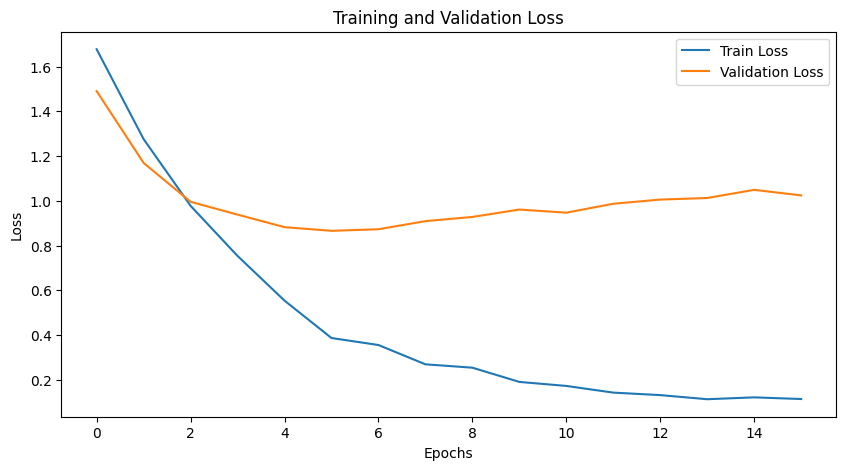

In [ ]:
# 학습 실행
train_losses, val_losses = train_age_group_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

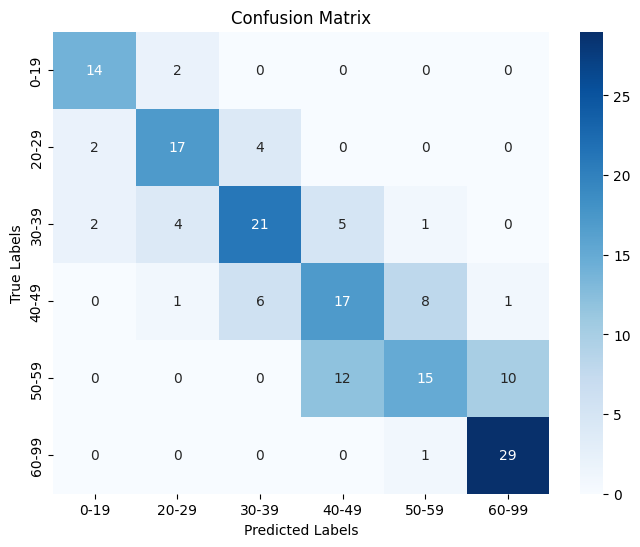

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# 혼동행렬 생성
val_labels = []  # 실제 레이블 리스트
val_preds = []   # 예측 레이블 리스트

model.eval()  # 평가 모드
with torch.no_grad():
    for images, ages in val_loader:
        images = images.to(device)
        age_groups = torch.tensor([age_to_age_group(age) for age in ages.cpu().numpy()]).to(device).long()

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        val_labels.extend(age_groups.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

# 혼동행렬 계산
conf_matrix = confusion_matrix(val_labels, val_preds)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"{age_intervals[i]}-{age_intervals[i+1]-1}" for i in range(num_classes)], yticklabels=[f"{age_intervals[i]}-{age_intervals[i+1]-1}" for i in range(num_classes)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 현재 노트북 파일을 Google Drive로 복사 (경로 설정은 자유롭게 조정 가능)
!cp "/content/your_notebook.ipynb" "/content/drive/MyDrive/your_notebook_backup.ipynb"

Mounted at /content/drive
cp: cannot stat '/content/your_notebook.ipynb': No such file or directory


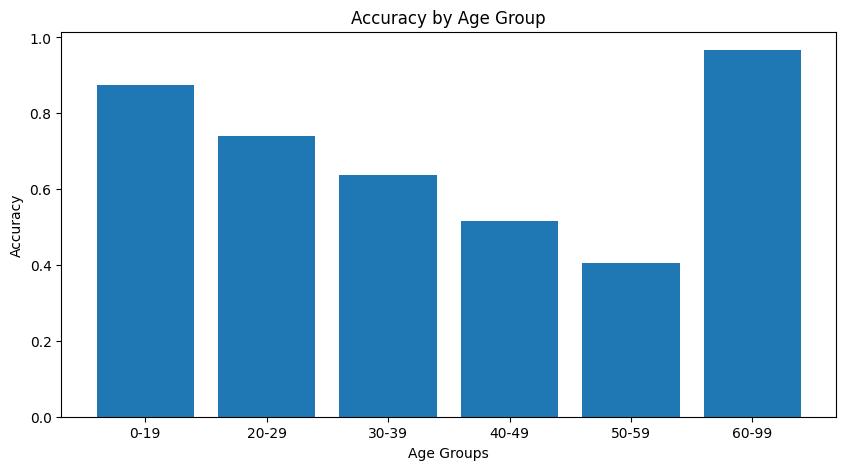

In [ ]:
import numpy as np

class_accuracies = []
for i in range(num_classes):
    class_correct = sum((np.array(val_labels) == i) & (np.array(val_preds) == i))
    class_total = sum(np.array(val_labels) == i)
    accuracy = class_correct / class_total if class_total > 0 else 0
    class_accuracies.append(accuracy)

plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), class_accuracies, tick_label=[f"{age_intervals[i]}-{age_intervals[i+1]-1}" for i in range(num_classes)])
plt.xlabel('Age Groups')
plt.ylabel('Accuracy')
plt.title('Accuracy by Age Group')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precisions = precision_score(val_labels, val_preds, average=None)
recalls = recall_score(val_labels, val_preds, average=None)
f1_scores = f1_score(val_labels, val_preds, average=None)

x = np.arange(num_classes)
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, precisions, width=0.2, label='Precision')
plt.bar(x, recalls, width=0.2, label='Recall')
plt.bar(x + 0.2, f1_scores, width=0.2, label='F1 Score')

plt.xlabel('Age Groups')
plt.ylabel('Score')
plt.xticks(x, [f"{age_intervals[i]}-{age_intervals[i+1]-1}" for i in range(num_classes)])
plt.title('Precision, Recall, and F1 Score by Age Group')
plt.legend()
plt.show()

NameError: name 'val_labels' is not defined

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 현재 노트북 파일을 Google Drive로 복사 (경로 설정은 자유롭게 조정 가능)
!cp "/content/your_notebook.ipynb" "/content/drive/MyDrive/your_notebook_backup.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/your_notebook.ipynb': No such file or directory
